In [26]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import ast

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *
from ModelSelection import *

%matplotlib inline

In [27]:
tr_norm_df = pd.read_csv('../data/divided_std_train_0_8.csv')
test_norm_df = pd.read_csv('../data/divided_std_test_0_2.csv')

tr_df = pd.read_csv('../data/divided_train_0_8.csv')
test_df = pd.read_csv('../data/divided_test_0_2.csv')

ML_cup_train = pd.read_csv('../data/ML-CUP23-TR.csv', header=None, index_col=0, comment='#')

TR_INPUT = 10
TR_OUTPUT = 3

tr_normalized = tr_norm_df.values
test_normalized = test_norm_df.values
training_set = tr_df.values
test_set = test_df.values

scaler_out = StandardScaler()
scaler_out.fit(ML_cup_train.values[:,TR_INPUT:])

training_len = len(tr_norm_df)
test_len = len(test_norm_df)

In [28]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

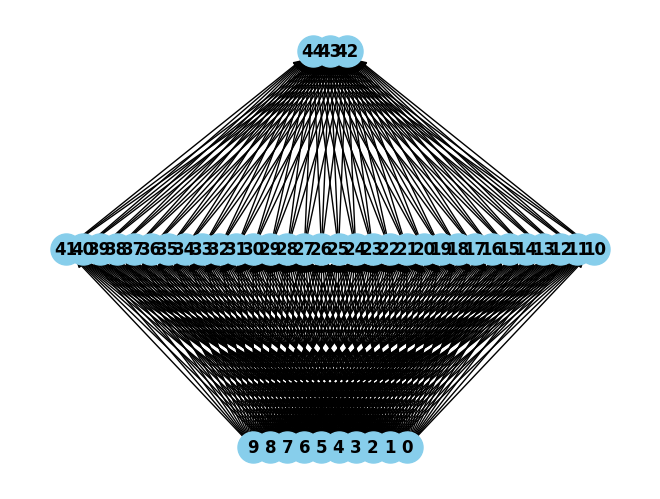

In [29]:
hidden_len = 32
hidden_fun = 'sigmoid'
output_fun = 'identity'
sigmoid_l1 = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [[hidden_fun, [1]]]*hidden_len + [[output_fun, []]]*TR_OUTPUT)
NeuralNetwork.display_topology(sigmoid_l1)

In [30]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

In [31]:
def remove_useless_val(x):
    a =['learning_rate', 'lr_decay_tau', 'alpha_momentum']
    b =['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2']
    if x['adamax']:
        for i in a:
            if i in x.keys():
                x[i] = None
    else:
        for i in b:
            if i in x.keys():
                x[i] = None   
    return x

In [32]:
columns_order = ['topology', 'stats',
 'batch_size',
 'min_epochs',
 'max_epochs',
 'patience',
 'error_increase_tolerance',
 'lambda_tikhonov',
 
 'learning_rate',
 'alpha_momentum',
 'lr_decay_tau',
 
 'adamax',
 'adamax_learning_rate',
 'exp_decay_rate_1',
 'exp_decay_rate_2',
 
 'mean_mean_euclidean_error',
 'mean_mean_squared_error',
 'var_mean_euclidean_error',
 'var_mean_squared_error',
 'mean_best_validation_training_error']

In [33]:
results_files = ['bagging_model.csv']
topologies = ['32_sigmoid']
folder = '../data/gs_data/'
topologies_dict = {}
gs_results = []
for i, f in enumerate(results_files):
    if os.path.isfile(folder+ f):
        dummy = pd.read_csv(folder + f)
        topologies_dict[topologies[i]] = ast.literal_eval(dummy['topology'][0])
        dummy['topology'] = topologies[i]
        
        gs_results.append(dummy)
    


orig_df = pd.concat(gs_results)

In [34]:
columns_order = [x for x in columns_order if x in orig_df.columns]
orig_df = orig_df[columns_order]

order_by = 'mean_mean_euclidean_error'
orig_df.sort_values(by=[order_by], inplace=True)
orig_df = orig_df.reset_index(drop=True)
gs_results = orig_df.drop(['stats'], axis=1)

In [35]:
gs_results = gs_results.apply(remove_useless_val, axis=1)
for i in gs_results.columns[1:]:
    gs_results[i] = gs_results[i].astype(float)

In [36]:
numerical_col = list(gs_results.columns)
numerical_col.remove('topology')
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
tr_input_col = [item for item in list(gs_results.columns) if item not in metrics_col]

In [37]:
n_models = 18
tr_len = 533
max_epochs = 500
mod = []

met = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error, ]

In [38]:
if False:
    interesting_model = load_obj('../data/net/models_6_ens/models.json')
    interesting_model_2 = load_obj('../data/net/models_6_ens_retr_giacomo/models.json')
    interesting_model_3 = load_obj('../data/net/models_6_ens_retr_jacopo/models.json')

    scarto = 8
    for i, el in enumerate(interesting_model_2):
        el['nn_file_name'] = '../data/net/models_6_ens/model_' + str(i + scarto) + '.json'
        el['index'] = i + scarto
    interesting_model += interesting_model_2
    scarto = 8 + 6
    for i, el in enumerate(interesting_model_3):
        el['nn_file_name'] = '../data/net/models_6_ens/model_' + str(i + scarto) + '.json'
        el['index'] = i + scarto
    interesting_model += interesting_model_3

    with open('../data/net/models_6_ens/ens_curves_tr.json', 'r') as file:
        predictions_accumul_tr = np.array(json.load(file))
    with open('../data/net/models_6_ens/ens_curves_test.json', 'r') as file:
        predictions_accumul_test = np.array(json.load(file))

    with open('../data/net/models_6_ens_retr_giacomo/ens_curves_tr.json', 'r') as file:
        predictions_accumul_tr += np.array(json.load(file))
    with open('../data/net/models_6_ens_retr_giacomo/ens_curves_test.json', 'r') as file:
        predictions_accumul_test += np.array(json.load(file))
        
    with open('../data/net/models_6_ens_retr_jacopo/ens_curves_tr.json', 'r') as file:
        predictions_accumul_tr += np.array(json.load(file))
    with open('../data/net/models_6_ens_retr_jacopo/ens_curves_test.json', 'r') as file:
        predictions_accumul_test += np.array(json.load(file))
        
    with open('../data/net/models_6_ens/models.json', 'w+') as file:
        save_obj(interesting_model, file)
        
    with open('../data/net/models_6_ens/ens_curves_tr.json', 'w+') as file:
        file.write(json.dumps(predictions_accumul_tr.tolist()))
    with open('../data/net/models_6_ens/ens_curves_test.json', 'w+') as file:
        file.write(json.dumps(predictions_accumul_test.tolist()))

In [39]:
interesting_model = load_obj('../data/net/models_6_ens/models.json')
with open('../data/net/models_6_ens/ens_curves_tr.json', 'r') as file:
    predictions_accumul_tr = np.array(json.load(file))/n_models
with open('../data/net/models_6_ens/ens_curves_test.json', 'r') as file:
    predictions_accumul_test = np.array(json.load(file))/n_models

In [40]:
predictions_accumul_tr.shape

(500, 800, 3)

In [41]:
'''for dummy in interesting_model:
    stats = dummy['stats']
    fig, ax = plt.subplots(1, len(met), figsize=(12, 5))
    plt.suptitle('Training Metrics ' + dummy['top_name'] + '_' + str(dummy['index']))
    for i in range(len(met)):
        multy_plot([stats['training_' + met[i].__name__], stats['validation_' + met[i].__name__]], 
                ['tr_' + met[i].__name__, 'val_' + met[i].__name__],
                ax=ax[i])'''

"for dummy in interesting_model:\n    stats = dummy['stats']\n    fig, ax = plt.subplots(1, len(met), figsize=(12, 5))\n    plt.suptitle('Training Metrics ' + dummy['top_name'] + '_' + str(dummy['index']))\n    for i in range(len(met)):\n        multy_plot([stats['training_' + met[i].__name__], stats['validation_' + met[i].__name__]], \n                ['tr_' + met[i].__name__, 'val_' + met[i].__name__],\n                ax=ax[i])"

In [42]:
def ensemble(compl_obj, set):

    output = []#np.empty((len(set), TR_OUTPUT))
    
    for el in set:
        dummy = np.zeros(TR_OUTPUT)
        for j in range(len(compl_obj)):
            dummy += compl_obj[j]['model'].predict(el)

        output.append(dummy/len(compl_obj))
        #print(dummy/len(compl_obj))
        
    return output
    

In [43]:
str_prediction_tr = ensemble(interesting_model, tr_normalized[:,:TR_INPUT])
str_prediction_test = ensemble(interesting_model, test_normalized[:,:TR_INPUT])

prediction_tr = scaler_out.inverse_transform(str_prediction_tr)
prediction_test = scaler_out.inverse_transform(str_prediction_test)

std_error_tr = ErrorFunctions.mean_euclidean_error(str_prediction_tr, tr_normalized[:,TR_INPUT:])
std_error_test = ErrorFunctions.mean_euclidean_error(str_prediction_test, test_normalized[:,TR_INPUT:])

error_tr = ErrorFunctions.mean_euclidean_error(prediction_tr, training_set[:,TR_INPUT:])
error_test = ErrorFunctions.mean_euclidean_error(prediction_test, test_set[:,TR_INPUT:])

In [44]:
print('std_error_tr:', std_error_tr)
print('std_error_test:', std_error_test)
print('error_tr:', error_tr)
print('error_test:', error_test)

std_error_tr: 0.06946881385245188
std_error_test: 0.06773117550588019
error_tr: 1.3911734269354679
error_test: 1.376647727915693


In [45]:
ens_err_test = [[], []]
ens_err_train = [[], []]

for i in range(len(met)):
    for epoch in range(max_epochs):
        ens_err_train[i].append(met[i](predictions_accumul_tr[epoch], tr_normalized[:,TR_INPUT:]))
        ens_err_test[i].append(met[i](predictions_accumul_test[epoch], test_normalized[:,TR_INPUT:]))

In [46]:
dat = pd.DataFrame({'tr_MEE':ens_err_train[1], 'tr_MSE':ens_err_train[0],
                    'test_MEE':ens_err_test[1], 'test_MSE':ens_err_test[0]})

a = px.line(dat)
a.show()

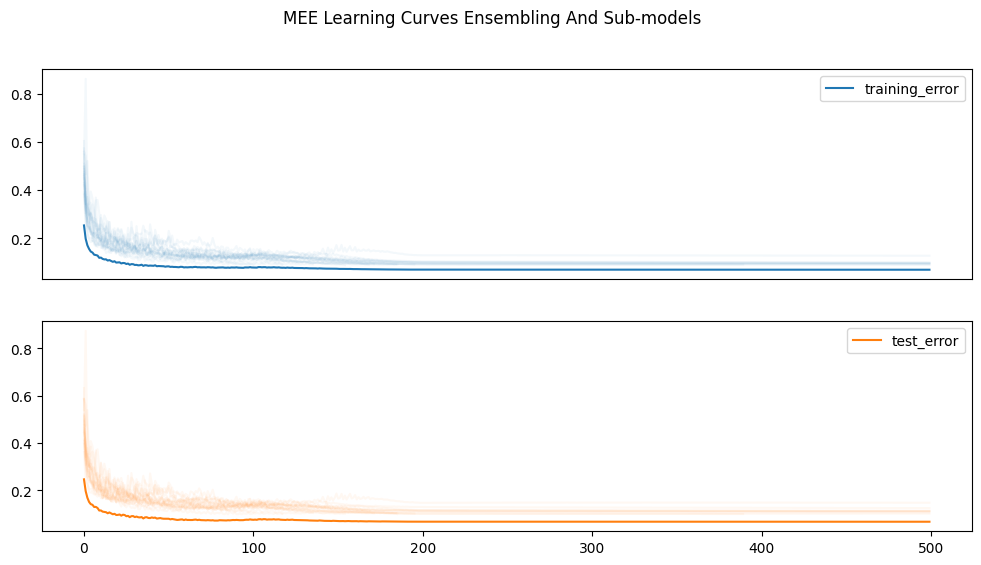

In [47]:
fig, axs = plt.subplots(2, figsize=(12,6))
fig.suptitle('MEE Learning Curves Ensembling And Sub-models')

for dummy in interesting_model:
    stats = dummy['stats']
        
    axs[0].plot(list(range(len(stats['training_mean_euclidean_error']))), stats['training_mean_euclidean_error'], color = 'C0', alpha=0.05)
    axs[1].plot(list(range(len(stats['validation_mean_euclidean_error']))), stats['validation_mean_euclidean_error'], color = 'C1', alpha=0.05)
    
    
axs[0].plot(list(range(len(ens_err_train[1]))), ens_err_train[1], color='C0', label='training_error')
axs[1].plot(list(range(len(ens_err_test[1]))), ens_err_test[1], color = 'C1', label='test_error')

axs[0].set_xticks([])
axs[0].legend()
axs[1].legend();

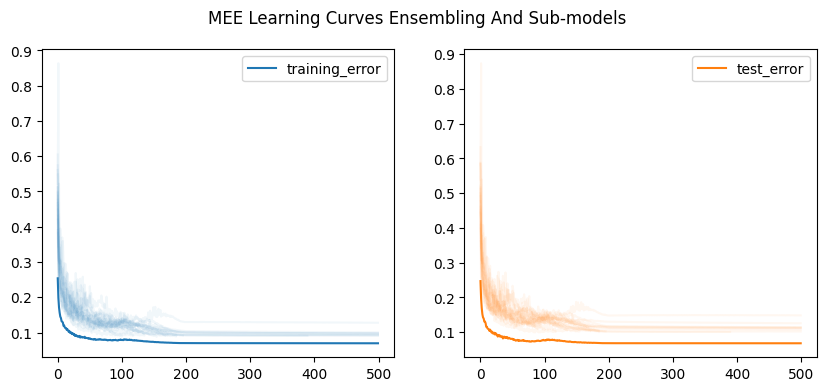

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('MEE Learning Curves Ensembling And Sub-models')

for dummy in interesting_model:
    stats = dummy['stats']
        
    ax1.plot(list(range(len(stats['training_mean_euclidean_error']))), stats['training_mean_euclidean_error'], color = 'C0', alpha=0.06)
    ax2.plot(list(range(len(stats['validation_mean_euclidean_error']))), stats['validation_mean_euclidean_error'], color = 'C1', alpha=0.06)
    
    
ax1.plot(list(range(len(ens_err_train[1]))), ens_err_train[1], color = 'C0', label='training_error')
ax2.plot(list(range(len(ens_err_test[1]))), ens_err_test[1], color = 'C1', label='test_error')

ax1.legend()
ax2.legend();

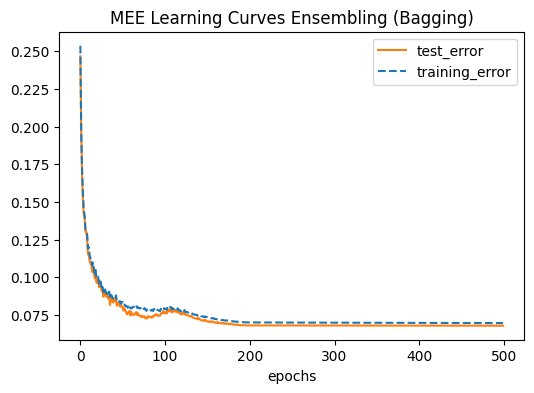

In [49]:
fig, ax = plt.subplots(figsize=(6,4))  # Create a figure containing a single axes.

ax.plot(list(range(len(ens_err_test[1]))), ens_err_test[1], label='test_error', color='C1', linestyle='-')
ax.plot(list(range(len(ens_err_train[1]))), ens_err_train[1], label='training_error',  color='C0', linestyle='--')

ax.set_title('MEE Learning Curves Ensembling (Bagging)')
ax.set_xlabel('epochs')
ax.legend();

In [50]:
ensemble(interesting_model, tr_normalized[0:1,:TR_INPUT])

[array([ 0.54842947,  0.90856352, -1.09049605])]